In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#from qiskit.quantum_info import state_fidelity
# import basic plot tools
from qiskit.tools.visualization import plot_histogram
from sklearn.preprocessing import MinMaxScaler
from qiskit.aqua.components.feature_maps.raw_feature_vector import RawFeatureVector
from mpl_toolkits.mplot3d import Axes3D
#import random
#from sklearn.cluster import KMeans
import centroid_initialization as cent_init
#from qiskit.quantum_info import Statevector
import warnings
#from sklearn.preprocessing import FunctionTransformer
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.20.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': '0.8.2', 'qiskit': '0.36.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
#PROCESSING THE DATA
def get_data(n,k,std):
    data = make_blobs(n_samples=n, n_features=3, centers=k, cluster_std=std, center_box=(-10,10), random_state=10)
    points = data[0]
    centers = data[1]
    return points,centers
def get_massless_vectors(points):
    fourvector=[]
    for i in range(len(points)):
        aux=np.append(points[i,:], (points[i,0]**2+points[i,1]**2+points[i,2]**2)**0.5)
        aux1=aux.copy()
        aux1[0]=aux[3]
        aux1[1]=aux[0]
        aux1[2]=aux[1]
        aux1[3]=aux[2]
        fourvector+=[aux1]
    return fourvector

def preprocess(points):
    scaler =MinMaxScaler(feature_range=(10, 100))
    points=scaler.fit_transform(points)
    return points


In [32]:
#PLOTTING INTERMEDIATE RESULTS
def draw_plot(fig,points,centers,label=True):
    
    ax = Axes3D(fig)
    ax.scatter(points[:,1], points[:,2],points[:,3],c=centers, cmap='viridis') #4dimensions
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    #fig.add_axes(ax)
    plt.show()
    
def plot_centroids(fig,points,centers):
    
    ax = Axes3D(fig)
    ax.scatter(points[:,1], points[:,2],points[:,3])  #4dimensions
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    #fig.add_axes(ax)
    plt.show()

In [33]:
#UTILS FOR THE ALGORITHM

def initialize_center(points):
    center=[]
    for i in range(len(points[0,:])):
        center=np.append(center,np.random.uniform(min(points[:,i]),max(points[:,i])))
    return center
def initialize_centers(points,k):
    centers=[]
    for i in range(k):
        centers=np.append(centers,initialize_center(points))
    centers=centers.reshape(k,len(points[0,:]))
    return centers

def find_centroids(points,centers,k):
    n = len(points)
    #k = int(np.max(centers))+1
    #print(k)
    #centroids = np.zeros([k,3])#before 4
    centroids = np.zeros([k,4])
    for i in range(k):
        #print(points[centers==i])
        if (np.size(points[centers==i])!=0):
            centroids[i,0] = np.average(points[centers==i,0])
            centroids[i,1] = np.average(points[centers==i,1])
            centroids[i,2] = np.average(points[centers==i,2])
            centroids[i,3] = np.average(points[centers==i,3])
            
        #print(centroids[i,:])
        else:
            centroids[i]=points[np.random.randint(points.shape[0]),:]
        
    return centroids  
def find_nearest_neighbour_quantum(points,centroids,k,quantum,qsearch):
    n = len(points)
    centers = np.zeros(n)
    
    for i in range(n):
        min_dis = 10**10
        ind = 0
        temp_dis_list=[]
        for j in range(k):

            if (quantum == True) :
                error=True
                while(error==True):
                    temp_dis,error= quantum_calculate_mass_invariant(centroids[j,:],points[i,:])           
            else:        
                temp_dis = get_invariantmass_classical(centroids[j,:],points[i,:])
            temp_dis_list.append(temp_dis+1)            
        if(qsearch==True):
            index_min=get_quantum_minimum(temp_dis_list)
        else:
            index_min=np.argmin(temp_dis_list)
        centers[i] = index_min
    return (centers)

In [34]:
# DISTANCE CALCULATIONS
def get_minkwoski_distance_classical(p1, p2):
    dis=abs((p1[0]-p2[0])**2-get_distance_classical(p1[1:],p2[1:])**2)**0.5
    return dis
def get_invariantmass_classical(p1, p2):
    dis=abs((p1[0]+p2[0])**2-(p1[1]+p2[1])**2-(p1[2]+p2[2])**2-(p1[3]+p2[3])**2)**0.5
    return dis
def get_distance_classical(p1, p2):
    return np.sqrt(np.sum((p1-p2)*(p1-p2)))

def quantum_calculate_mass_invariant(x, y):
    backend = Aer.get_backend('qasm_simulator') 
    X = np.array(x[1:4])
    Y = np.array(y[1:4])
    error=False
    if (X[0]==Y[0] and X[1]==Y[1] and X[2]==Y[2]):
        #print('broken')
        return 0,error
        #feature vector converter
    c0 = ClassicalRegister(1)
    q0 = QuantumRegister(1)
    zerocircuit = QuantumCircuit(q0)
    zerocircuit.h(q0)

    fvc = RawFeatureVector(len(X))
    q1 = QuantumRegister(fvc.num_qubits)
    q2 = QuantumRegister(fvc.num_qubits)
    ketxcircuit = fvc.construct_circuit(X, qr=q1)
    ketycircuit = fvc.construct_circuit(Y, qr=q2)

    psicircuit = zerocircuit+ketxcircuit+ketycircuit
    for i in range(fvc.num_qubits):
        psicircuit.cswap(q0, q1[i], q2[i])

    #psicircuit.barrier(q0, q1, q2)


    gatexinverse=ketxcircuit.to_gate().inverse()
    gatexinverse.name="X_inverse"
    gatexinverse=gatexinverse.control(1)
    gateyinverse=ketycircuit.to_gate().inverse()
    gateyinverse.name="Y_inverse"
    gateyinverse=gateyinverse.control(1)

    psicircuit.append(gatexinverse,[0,q2[0],q2[1]])  
    psicircuit.x(q0)
    psicircuit.append(gateyinverse,[0,q2[0],q2[1]]) 
    psicircuit.x(q0)
    Z=0
    for i in range(len(X)):
        Z += X[i]**2+Y[i]**2

    fvc2 = RawFeatureVector(2)
    p1 = np.linalg.norm(X)
    p2 = np.linalg.norm(Y)
    phi = np.array([p1,p2])
    phicircuit = fvc2.construct_circuit(phi, qr=q2)

    q3 = QuantumRegister(1)
    swapcircuit = psicircuit+phicircuit
    swapcircuit.add_register(q3)
    swapcircuit.add_register(c0)
    swapcircuit.h(q3)
    swapcircuit.cswap(q3, q0, q2[0])
    swapcircuit.h(q3)
    swapcircuit.measure(q3, c0)
    swapcircuit.barrier(q0,q1,q2,q3)

    #new things
    q4 = QuantumRegister(1)
    q5 = QuantumRegister(1)
    q6 = QuantumRegister(1)
    phi = np.array([x[0],y[0]])
    Z0=x[0]**2+y[0]**2
    phicircuit = fvc2.construct_circuit(phi, qr=q4)
    swapcircuit=swapcircuit+phicircuit
    swapcircuit.add_register(q5)
    swapcircuit.add_register(q6)
    swapcircuit.h(q5)
    swapcircuit.h(q6)
    c1 = ClassicalRegister(1)
    swapcircuit.cswap(q6, q5, q4)
    swapcircuit.add_register(c1)
    swapcircuit.h(q6)
    swapcircuit.measure(q6, c1)
    #end new things
    
    #print(swapcircuit.draw('latex_source'))
    shots=50000
    result = execute(swapcircuit, backend, shots=shots).result()
    #print(result.get_counts())
    if('1 0' in result.get_counts()):
         p0=(result.get_counts()['1 0']+result.get_counts()['0 0'])/shots
    else:
        p0=(result.get_counts()['0 0'])/shots
    if('0 1' in result.get_counts()):
        p02=(result.get_counts()['0 0']+result.get_counts()['0 1'])/shots
    else:
        p02=(result.get_counts()['0 0'])/shots
    #squares = Z*((4*result.get_counts()['0']/50000.0)-2)
    tridistance = (Z*(4*p0-2))
    difmodulus=(Z0*(4*p02-2))
    
    if (tridistance<0 or difmodulus<0 ):
        error=True
    minkq2=abs(difmodulus-tridistance)**0.5
    #error =False
    return(minkq2,error)

In [35]:
# QUANTUM MINIMUM OBTENTION
   
def get_quantum_maximum(array):
    backend = Aer.get_backend('qasm_simulator') 
    X=np.array(array)
    fvc = RawFeatureVector(len(X))
    q1 = QuantumRegister(fvc.num_qubits)
    minimum_circuit = fvc.construct_circuit(X, qr=q1)
    minimum_circuit.measure_all()
    result = execute(minimum_circuit, backend, shots=600).result()
    counts=result.get_counts()
    max_value = max(counts.values())
    max_values_counts = [x[0] for x in counts.items() if x[1] == max_value]
    #result=counts.most_frequent()
    result=max_values_counts[0]
    index_minimum=int(result,2)
    return index_minimum
def get_quantum_minimum(array):
    array_power=np.array(array)**1
    array_inv=1/array_power
    index_min=get_quantum_maximum(array_inv)
    return index_min

In [36]:
#POST-PROCESSING RESULTS
def sum_array(arr):
    sum = 0;   
    #Loop through the array to calculate sum of elements  
    for j in range(0,len(arr[0,:])):
        for i in range(0, len(arr[0,:])):  
           sum = sum + arr[j,i]; 
    return abs(sum)
def centroids_differences(centroidslist,trials,limit,counts):
    
    for i in range(trials-1):
        for j in range(i+1,trials):
            if(sum_array(centroidslist[i]-centroidslist[j])<=limit):
                counts[i]+=1
                counts[j]+=1
                #i=trials
                #j=trials
    return counts


def makeitinteger(centers):
    intcenters=[int(centers[0])]
    for i in range(1,len(centers)):
        integer=int(centers[i])
        intcenters=np.append(intcenters,int(integer))
    return intcenters
def compute_efficiency(o_centers,intcenters):
    eff=0
    for i in range(len(intcenters)):
        if (o_centers[i]==intcenters[i]):
            eff+=1
    return (eff/len(intcenters))
def changing_index(a,b,intcenters):
    intcentersaux=np.where(intcenters==a, b,intcenters)
    intcenters=np.where(intcenters==b,a,intcentersaux)
    return intcenters
def final_efficiency(o_centers,centers,k):
    effmax=0
    intcenters=makeitinteger(centers)
    goodcenters=intcenters.copy()
    for i in range(0,k-1):
        for j in range(0,k):#1
            intcentersaux=changing_index(i,j,intcenters)
            
            eff=compute_efficiency(o_centers,intcentersaux)
            
            if(eff>effmax):
                effmax=eff
                goodcenters=intcentersaux
    return (effmax,goodcenters)
def final_efficiency_converged(o_centers,centers,k):
    intcenters=makeitinteger(centers)
    stop=0
    ef,intcenters=final_efficiency(o_centers,intcenters,k)# we are changing intcenters 
    while (stop==0):
        efprime,intcentersprime=final_efficiency(o_centers,intcenters,k)
        if (efprime==ef):
            stop=1
        else:
            ef=efprime
            intcenters=intcentersprime
    return (ef,intcenters)

In [40]:
# MAIN ALGORITHM
def run_kmeans(n,k,std,massless,trials,iterations,limit,quantum,qsearch,random_init=True):
    points,o_centers = get_data(n,k,std)
    points = preprocess(points)# Normalize dataset
    if(massless==True):
        points=np.array(get_massless_vectors(points))
    centroidslist=[]
    centerslist=[]
    for j in range(trials):
        if (random_init):
            centroids = initialize_centers(points,k)
        else:
            centroids = cent_init.plus_plus(points,k)
        
        for i in range(iterations):
            centers = find_nearest_neighbour_quantum(points,centroids,k,quantum,qsearch)
            centroids = find_centroids(points,centers,k) 
        centroids=np.sort(centroids,0)  
        
        
        centroidslist=np.append(centroidslist,centroids)
        centerslist=np.append(centerslist,centers)
        centroidslistgood=centroidslist.reshape(j+1,k,len(points[0,:]))
        centerslistgood=centerslist.reshape(j+1,len(centers))
        reducedcentroids,indices,counts=np.unique(centroidslistgood,1,0,1,0)
        if(max(counts)==3):
            j=2*trials
    fig=plt.figure()
    draw_plot(fig,points[:,:],centers)
    #plot_centroids(fig,points,centroids[:,:])
    if (max(counts)==1):
        #limit=10
        counts=centroids_differences(centroidslistgood,trials,limit,counts)
    res=final_efficiency_converged(o_centers,centerslistgood[indices[np.argmax(counts)]],k)
    return res,o_centers,centroidslistgood[indices[np.argmax(counts)]]


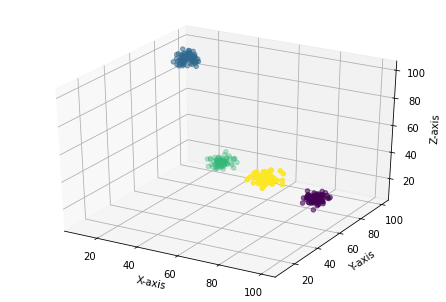

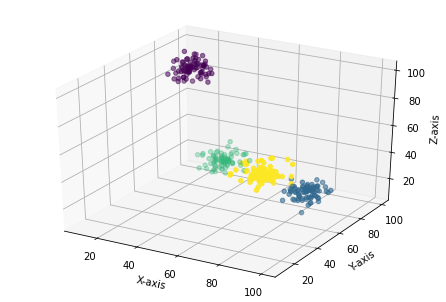

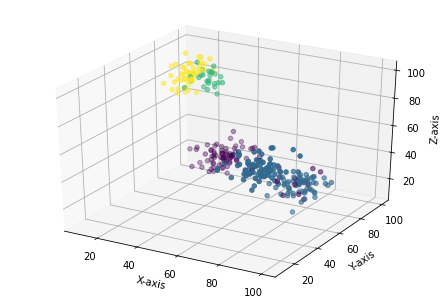

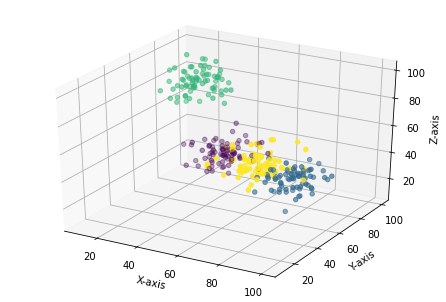

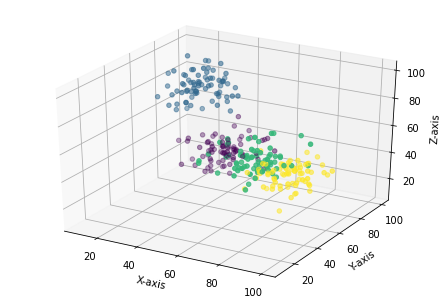

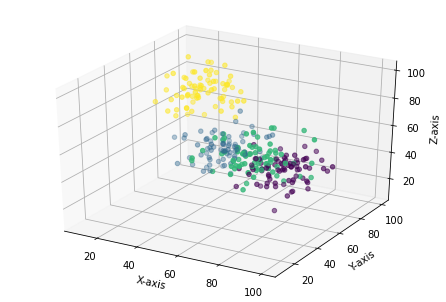

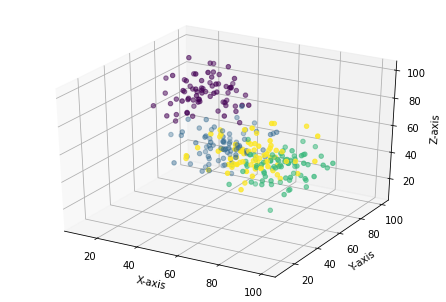

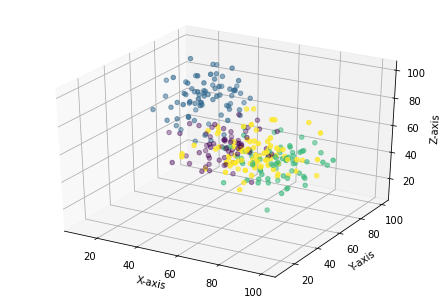

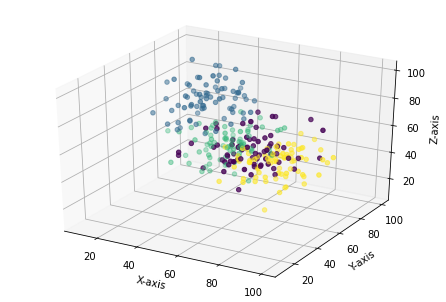

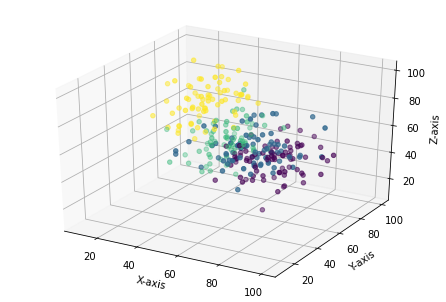

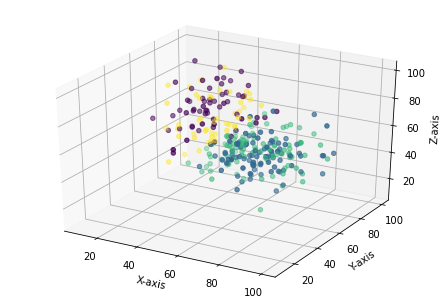

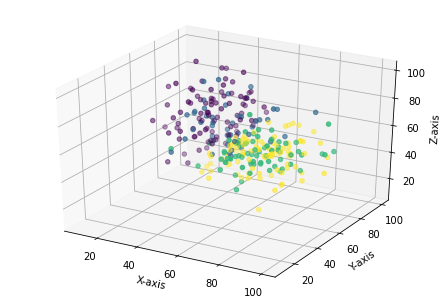

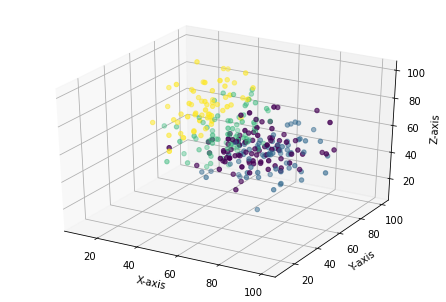

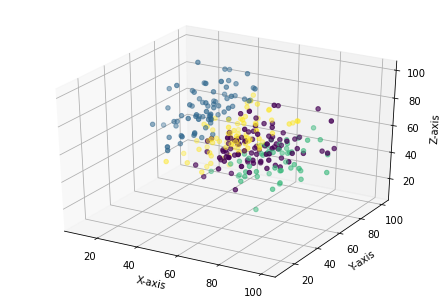

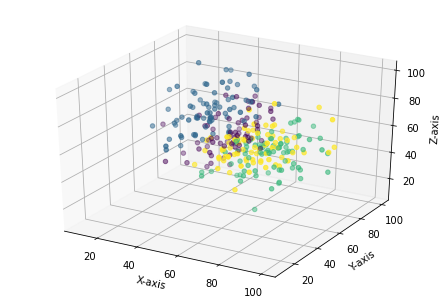

[1.0, 1.0, 1.0, 1.0, 0.9633333333333334, 0.9766666666666667, 0.9666666666666667, 0.8966666666666666, 0.91, 0.8466666666666667, 0.58, 0.7933333333333333, 0.7233333333333334, 0.6966666666666667, 0.6866666666666666]
15


In [42]:
#Classical K-means with classical minkowski distance calculation and classical search for the minima
#Using random initilization
n=300
k=4
effs=[]
#std=1

for std in range(1,16):
    massless= True
    trials=3
    iterations=5
    limit=10
    resul=run_kmeans(n,k,std/2,massless,trials,iterations,limit,
                     quantum=False,qsearch=False,random_init=True)
    effs.append(resul[0][0])
print(effs)
print(std)

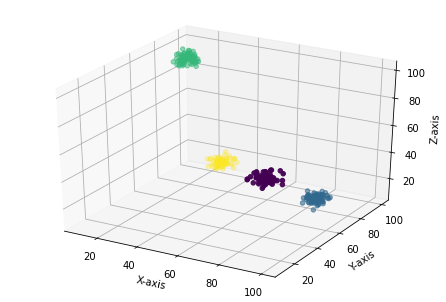

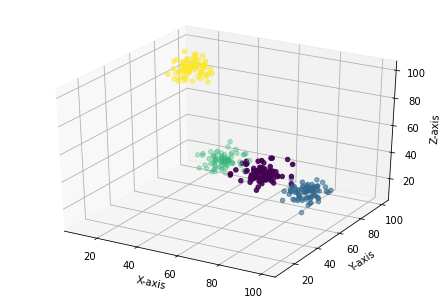

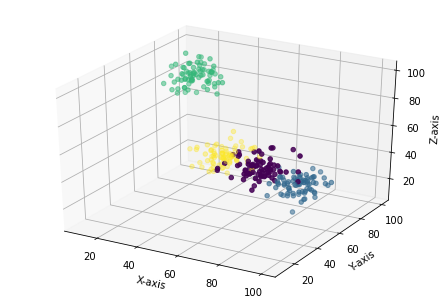

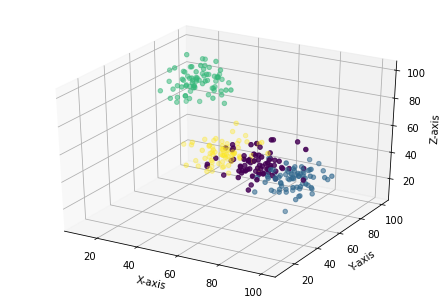

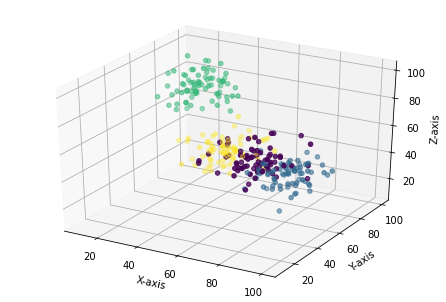

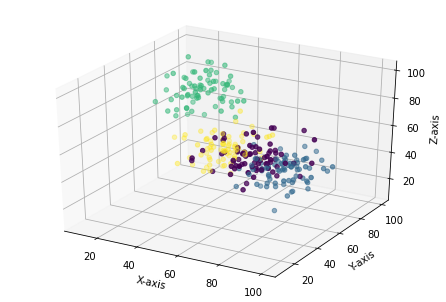

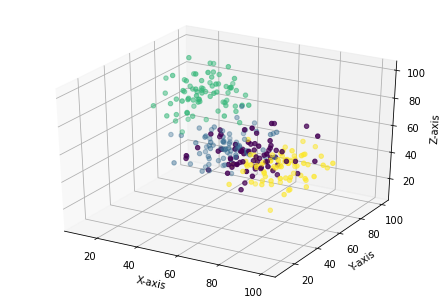

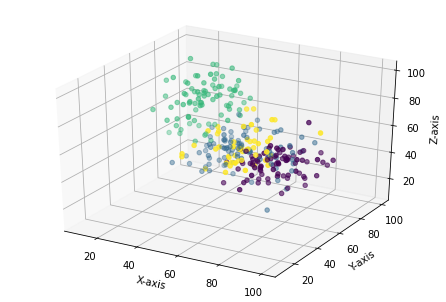

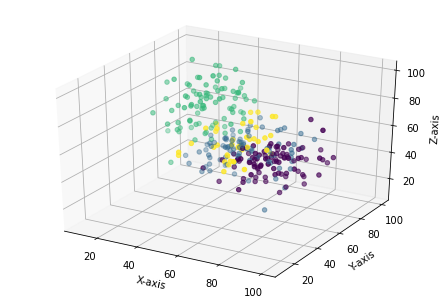

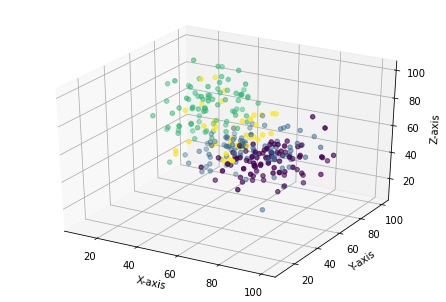

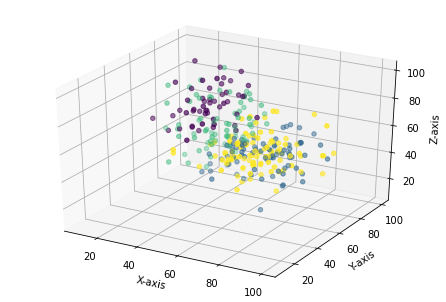

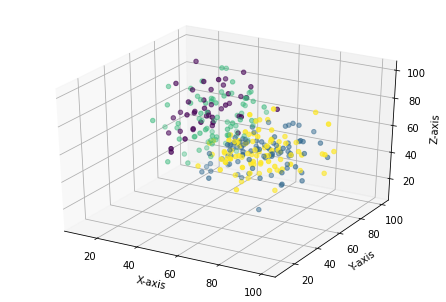

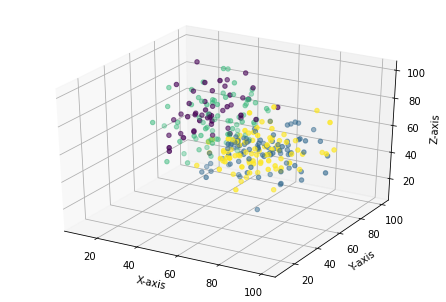

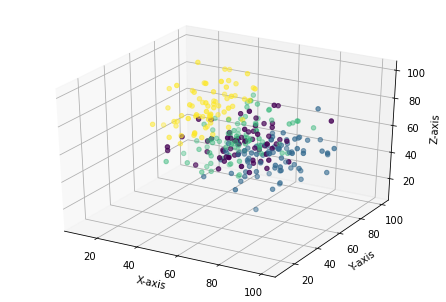

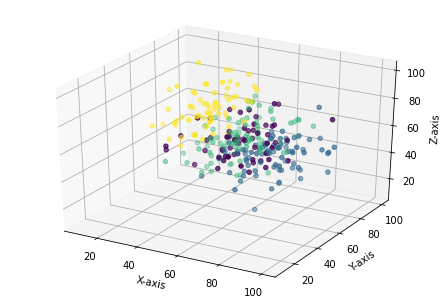

[1.0, 1.0, 1.0, 1.0, 0.9933333333333333, 0.98, 0.9633333333333334, 0.79, 0.7266666666666667, 0.6633333333333333, 0.69, 0.61, 0.5866666666666667, 0.7533333333333333, 0.72]
15


In [43]:
#Classical K-means with classical minkowski distance calculation and classical search for the minima
#Using Kmeans++ initilization
n=300
k=4
effs=[]
#std=1

for std in range(1,16):
    massless= True
    trials=3
    iterations=5
    limit=10
    resul=run_kmeans(n,k,std/2,massless,trials,iterations,limit,
                     quantum=False,qsearch=False,random_init=False)
    effs.append(resul[0][0])
print(effs)
print(std)

In [ ]:
# QUANTUM K-means with quantum minkowski distance calculation and quantum search for the minima
# Using random initilization
n=300
k=4
effs=[]
#std=1

for std in range(1,16):
    massless= True
    trials=3
    iterations=5
    limit=10
    resul=run_kmeans(n,k,std/2,massless,trials,iterations,limit,
                     quantum=True,qsearch=True,random_init=True)
    effs.append(resul[0][0])
print(effs)
print(std)

In [ ]:
#QUANTUM K-means with quantum minkowski distance calculation and quantum search for the minima
#Using Kmeans++ initilization
n=300
k=4
effs=[]
#std=1

for std in range(1,16):
    massless= True
    trials=3
    iterations=5
    limit=10
    resul=run_kmeans(n,k,std/2,massless,trials,iterations,limit,
                     quantum=True,qsearch=True,random_init=False)
    effs.append(resul[0][0])
print(effs)
print(std)